# Практический проект по анализу данных 


*Описание данных:*

Файл **events_train.csv** - данные о действиях, которые совершают студенты со стэпами:

1. **step_id** - id стэпа
2. **user_id** - анонимизированный id юзера
3. **timestamp** - время наступления события в формате unix date
4. **action** - событие, возможные значения: 
    - discovered - пользователь перешел на стэп;
    - viewed - просмотр шага;
    - started_attempt - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага;
    - passed - удачное решение практического шага.

Файл **submissions_train.csv** - данные о времени и статусах сабмитов к практическим задания:

1. **step_id** - id стэпа
2. **timestamp** - время отправки решения в формате unix date
3. **submission_status** - статус решения
4. **user_id** - анонимизированный id юзера





# Импорт

In [330]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve, auc

from sklearn.ensemble import RandomForestClassifier

In [331]:
sns.set(rc={'figure.figsize': (9, 6)})

# Чтение данных

In [332]:
events_data = pd.read_csv('event_data_train.csv')

In [333]:
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


# Изучение данных

Добавим столбцы **date** и **day** в *events_data*.

In [334]:
events_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [335]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
events_data['day'] = events_data.date.dt.date
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [336]:
events_data.dtypes

step_id               int64
timestamp             int64
action               object
user_id               int64
date         datetime64[ns]
day                  object
dtype: object

Посчитаем сколько уникальных пользователей посещают курс в каждый заданный день.

Для этого сгруппируем данные по столбцу **day** и воспользуемся функцией `nunique`.

<AxesSubplot:xlabel='day'>

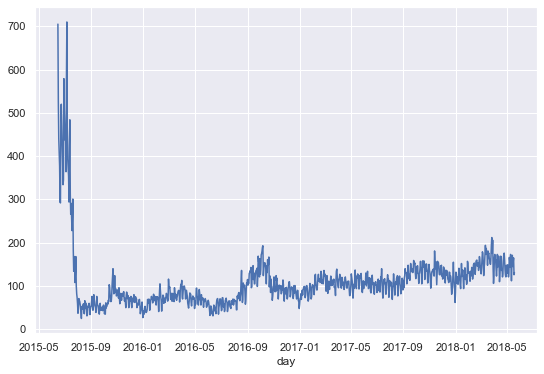

In [337]:
events_data.groupby('day').user_id.nunique().plot()

Как видно из графика временной отрезок данных с 2015-2018г. Также можно заметить некоторые закономерности, при старте курса записалось около 700 человек, далее записалось еще довольно много людей. У курса были дедлайны, юди продолжали записываться, чтобы успеть сдать задания в первую неделю.

Дальше курс закончился, какое-то время он дорабатывался, пользователи записывались менее активно, но с течением времени курс набирал популярность. 

Можно сделать вывод, что график отражает реальность и в данных нет серьезных ошибок.

Сгруппируем данные по пользователям и построим `гистограмму количества пройденных степов`. 

Переименуем колонку **step_id** в корректную для данного контекста **passed_steps**.

<AxesSubplot:>

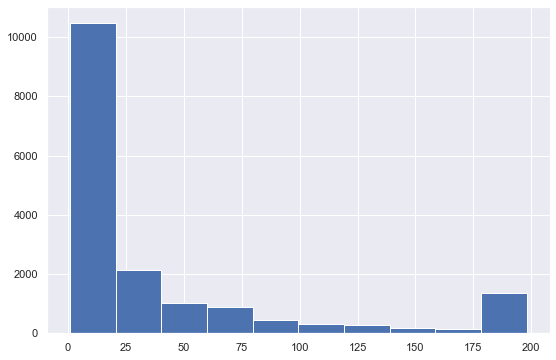

In [338]:
events_data[events_data.action  == 'passed'].groupby('user_id', as_index=False)\
        .agg({'step_id': 'count'})\
        .rename(columns={'step_id': 'passed_steps'}).passed_steps.hist()

Довольно большое колличесво людей курс начали и дальше все меньше и меньше людей, которые курс прошли, но некоторые еще не успели пройти до конца.


На первый взгляд график построен верно. 

Но, при построении гистограммы мы не учли пользователей, которые записались на курс, но не прошли ни одного степа. Вспользуемся функцией создания сводных таблиц - `pivot_table`, для более правильного решения.

In [339]:
users_events_data = events_data.pivot_table(index='user_id',
                                            columns='action',
                                            values='step_id', 
                                            aggfunc='count', 
                                            fill_value=0)
users_events_data.head()

action,discovered,passed,started_attempt,viewed
user_id,,,,
1,1,0,0,1
2,9,9,2,10
3,91,87,30,192
5,11,11,4,12
7,1,1,0,1


Сейчас в качестве индексов используется одна из колонок с данными, исправим представление данных с помощью `reset_index`.

In [340]:
users_events_data = users_events_data.reset_index()
users_events_data.columns.name = ''
users_events_data.head()

,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


<AxesSubplot:>

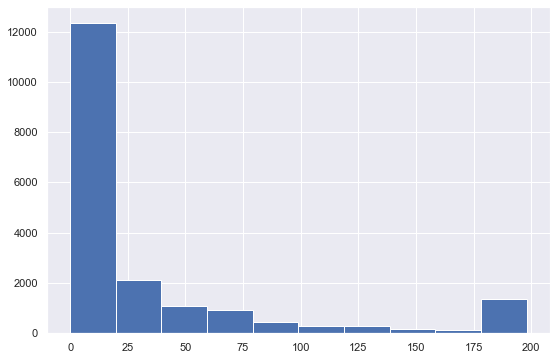

In [341]:
users_events_data.passed.hist()

Теперь гистограмма выглядит иначе, т.к. мы учли пользователей, которые не прошли ни одного степа.

Такую же сводную таблицу построим для файла **submissions_data.csv**.

In [342]:
submissions_data = pd.read_csv('submissions_data_train.csv')
submissions_data

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853
...,...,...,...,...
509099,120745,1501946959,wrong,2615
509100,120745,1503059927,correct,13177
509101,120745,1506348153,wrong,15253
509102,120745,1523035316,wrong,1424


In [343]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [344]:
users_scores_in_submissions = submissions_data.pivot_table(index='user_id', 
                                            columns='submission_status',
                                            values='step_id',
                                            aggfunc='count', 
                                            fill_value=0).reset_index()

In [345]:
users_scores_in_submissions.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


## Нахождение времени отсутсвия пользователя на курсе

Целью явдяется предсказание таких пользователей, которые бросают курс, не пройдя его до конца. 

Что можно сделать? 

Во-первых, важно разделить пользователей, которые временно приостановили прохождение курса, но планируют вернуться и пользователей, которые уже точно не вернутся на курс. Как их отличить? Например, мы можем исследовать активность пользователя с течением времени, и в случае, если на протяжении *n* дней пользователь не возвращался к курсу, то будем считать, что он уже не вернется. Попробуем определить, чему должно равняться *n* .

Для этого рассчитаем для каждого пользователя длительность перерывов между активностями на курсе. 

Далее посмотрим на картину в целом по всем пользователям и примем какое-то статистическое решение о том какую величину *n*  можно считать пороговой, чтобы относить пользователя к категории покинувших курс.


In [346]:
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day'])\
    .groupby('user_id')['timestamp'].apply(list)\
    .apply(np.diff).values
gap_data

array([array([], dtype=int32), array([4843602]),
       array([6899249,  182484,   93710, 2768870,  171400,   78712]), ...,
       array([   86128,   136759,    94899,  1422583, 14347289,   505061,
                 98252,    57019])                                       ,
       array([1567990]), array([], dtype=int32)], dtype=object)

Объединим все данные в один массив, каждый элемент будет представлять собой длительность промежутка бездействия пользователя (в днях) и построим `гистограмму`.

In [347]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))
gap_data = gap_data/ (24*60*60)
gap_data[:10]

0     56.060208
1     79.852419
2      2.112083
3      1.084606
4     32.047106
5      1.983796
6      0.911019
7    390.078843
8      9.994028
9      0.589468
dtype: float64

<AxesSubplot:>

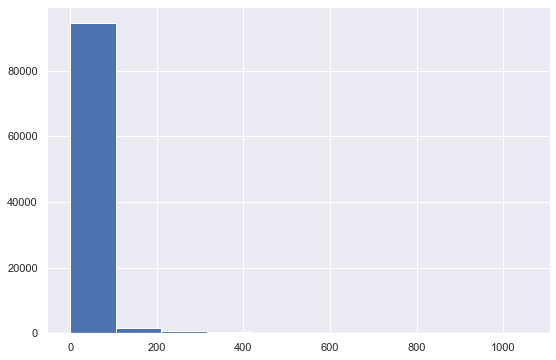

In [348]:
gap_data.hist()

Полученный график сложно интерпритировать - присутствуют большие выбросы. Поэтому необходимо отфильтровать данные. Для этого удалим слишком большие наблюдения (тех пользователей, у которых перерыв больше 200 дней).

<AxesSubplot:>

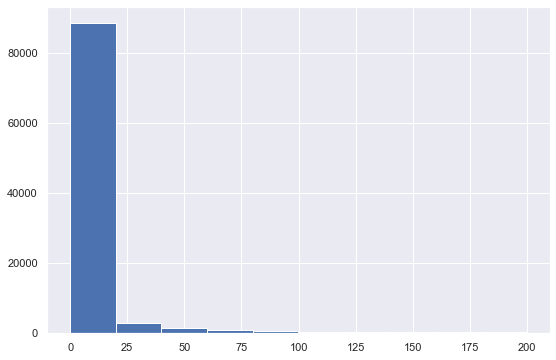

In [349]:
gap_data[gap_data < 200].hist()

Посмотрим какой порог времени бездействия не превышают 90% и 95% пользователей.

In [350]:
print(gap_data.quantile(0.95), "дней")
print(gap_data.quantile(0.90), "дней")

59.760440972222156 дней
18.325995370370403 дней


Получилось, что величина перерывов у 95% пользователей укладывается в 59 дней, а у 90% пользователей в 18 дней. 
Только 5% пользователей возращаются на курс после перерыва в 2 месяца.

На основании полученных результатов возьмем, например, 30 дней в качестве порогового значения промежутка бездействия.

# Разметка пользователей 

Разметим пользователей по принципу того являются ли они уже "дропнувшимися" или нет. При этом нужно понимать, что если пользователь долгое время не появляется на курсе, но при этом курс уже им пройден, то такого пользователя нельзя считать "дронувшимся".

Имеем составное условие: если человек еще не получил сертификат и при этом более 30 дней отсутствует на платформе, то помечаем его, как покинувшего курс.

In [351]:
events_data.tail()

,step_id,timestamp,action,user_id,date,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


В переменную `now` запишем время (`timestamp`) последнего события среди всех пользователей. 

В переменную `dropout_threshold` - значение 30 дней.

In [352]:
now = events_data['timestamp'].max()
dropout_threshold = 30 * 24 * 60 * 60
print('Time now:', now, '\nDropout threshold:', dropout_threshold)

Time now: 1526772811 
Dropout threshold: 2592000


In [353]:
users_data = events_data.groupby('user_id', as_index=False).\
            aggregate({'timestamp': 'max'}).rename(columns = {'timestamp': 'last_timestamp'})
users_data.head()

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660


In [354]:
users_data['is_gone_user'] = (now - users_data.last_timestamp) > dropout_threshold
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


Добавим к полученной таблице датафрейм с числом попыток решения степов и числом набранных баллов.

In [355]:
users_scores_in_submissions.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [356]:
users_data = users_data.merge(users_scores_in_submissions, on='user_id', how='outer')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,NaN,NaN
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,NaN,NaN


In [357]:
users_data = users_data.fillna(0)
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0


К полученной таблице присоединим еще один датафрейм с информацией о прочих действиях пользователя.

In [358]:
users_data = users_data.merge(users_events_data, how='outer')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1


Добавим еще один столбец с количеством дней, проведенных на курсе для каждого пользователя.

In [359]:
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()
users_days = users_days.rename(columns={'day': 'unique_days'})
users_days.head()

,user_id,unique_days
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1


In [360]:
users_data = users_data.merge(users_days, how='outer')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,unique_days
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


И обязательно проверям, что мы никого не потеряли.

In [361]:
print(users_data.user_id.nunique(), ' is equal', events_data.user_id.nunique())

19234  is equal 19234


Создадим еще одну колонку в данных, показывающую успешно ли пользователь закончил курс.

In [362]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,unique_days
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


In [363]:
users_data['passed_course'] = users_data.passed > 40
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,unique_days,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,True
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [364]:
users_data.groupby('passed_course').count()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,unique_days
passed_course,,,,,,,,,,
False,14596,14596,14596,14596,14596,14596,14596,14596,14596,14596
True,4638,4638,4638,4638,4638,4638,4638,4638,4638,4638


Найдем процент пользователей, успешно прошедших курс.

In [365]:
users_data['passed_course'].value_counts(normalize=True) 

False    0.758865
True     0.241135
Name: passed_course, dtype: float64

24% пользователей успешно закончили курс.

# Обучение модели

Дданные почти размечены и приведены к такому виду, чтобы их можно было подать на вход ML алгоритму.

Цель: мы хотим как можно раньше предсказывать по поведению пользователя уйдет ли он с курса или нет. Ведь если слишком поздно предсказать уход пользователя, то такой алгоритм окажется бесполезным. Поэтому нужно попробовать разные пороги и найти оптимальный баланс времени и качества. 

Первым делом, попробуем сделать прогноз, основываясь на 3 днях (`learning_time_threshold=3`) пользования курсом. Но сначала проверем на адекватность эту величину, т.к. мы взяли и ее произвоьным образом. Для этого подсчитаем медиану количества уникальных дней, проведенных пользователями на курсе. Причем будем делать подсчет только среди тех пользователей, которые успешно прошли курс.

In [366]:
users_data[users_data.passed_course].unique_days.median()

13.0

Медиана равна 12 дням. 

Построим `гистограмму`.

<AxesSubplot:>

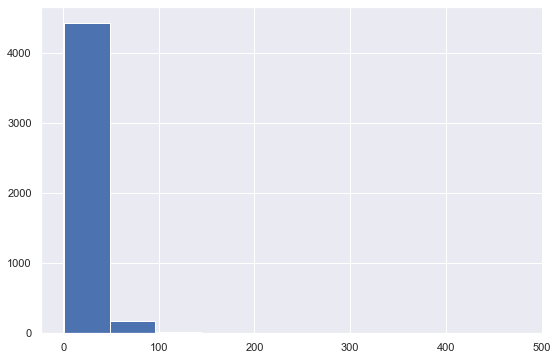

In [367]:
users_data[users_data.passed_course].unique_days.hist()

Первая задача - отобрать события, которые происходили с пользователем в течение первых 3-ех дней, из общего датафрейма **events_data**. Создадим датафрейм, где будет собраны данные о первой активности каждого пользователя на курсе:

In [368]:
user_min_time = events_data.groupby('user_id', as_index=False).\
                agg({'timestamp': 'min'}).rename({'timestamp': 'min_timestamp'}, axis=1)
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [369]:
users_data = users_data.merge(user_min_time, how='outer')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,unique_days,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,True,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


Отобрать события, которые происходили с пользователем в течение первых 3-ех дней, не самая тривиальная задача. Ее можно решить несколькими способами. 

Рассмотрим первый и не самый оптимальный способ через цикл `for`:

In [370]:
events_data_train = pd.DataFrame()

In [371]:
for user_id in users_data.user_id:
    min_user_time = users_data[users_data.user_id == user_id].min_timestamp.item()
    time_threshold = min_user_time + 3*24*60*60
    user_evnts_data = events_data[(events_data.user_id == user_id) & (events_data.timestamp < time_threshold)]
    events_data_train = events_data_train.append(user_evnts_data)
    break

In [372]:
events_data_train

,step_id,timestamp,action,user_id,date,day
1347416,31981,1472827464,viewed,1,2016-09-02 14:44:24,2016-09-02
1347417,31981,1472827464,discovered,1,2016-09-02 14:44:24,2016-09-02


Мы специально сделали только одну итерацию, т.к. этот подход очень ресурсозатратен по времени. Более правильным способом было бы произвести нужную нам фильтрацию, используя функционал pandas. Сделаем это снова двумя способами. 

Первый способ (самый оптимальный):

In [373]:
learning_time_threshold = 3*24*60*60

In [374]:
events_data = events_data.merge(user_min_time, how = 'outer')
events_data_train = events_data.query("timestamp <= min_timestamp + @learning_time_threshold")

In [375]:
events_data_train.shape

(1014985, 7)

In [376]:
events_data_train.head()

,step_id,timestamp,action,user_id,date,day,min_timestamp
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848


Второй способ немного более странный, но тоже имеет место быть (с конкатенацией строк). 

Создадим новую колонку **user_time** и сконкатенируем **user_id** с **timestamp**:

In [377]:
events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str)
events_data.head()

,step_id,timestamp,action,user_id,date,day,min_timestamp,user_time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,17632_1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,17632_1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848,17632_1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848,17632_1434340895
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848,17632_1434340895


In [378]:
events_data.shape

(3480703, 8)

In [379]:
user_learning_time_threshold = user_min_time.user_id.map(str) + '_' + (user_min_time.min_timestamp + learning_time_threshold).map(str)
user_learning_time_threshold

0            1_1473086664
1            2_1514642564
2            3_1434617676
3            5_1466416009
4            7_1521893860
               ...       
19229    26790_1451743216
19230    26793_1510484231
19231    26794_1495546249
19232    26797_1508684516
19233    26798_1521234963
Length: 19234, dtype: object

Получили серию, где каждая запись состоит из `id` пользователя, сконкатенированного со значением времени.

In [380]:
user_min_time['user_learning_time_threshold'] = user_learning_time_threshold

In [381]:
events_data = events_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')

In [382]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,min_timestamp,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848,17632_1434340895,17632_1434600048


In [383]:
events_data_train = events_data[events_data.user_time <= events_data.user_learning_time_threshold]
events_data_train.head()

,step_id,timestamp,action,user_id,date,day,min_timestamp,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848,17632_1434340895,17632_1434600048


Выполним проверку, что все подсчитано правильно:

In [384]:
events_data_train.groupby('user_id').day.nunique().max()

4

Получили 4 дня - это приемлемый результат. Т.к. если пользователь начал проходить курс 1-го мая в 21:00, то через трое суток будет уже 4-ое мая. Итого будем иметь 4 уникальных дня. А больше 4-х дней быть не должно.

# Подготовим такой же датасет на основе `submission_data`. 

In [385]:
submissions_data = submissions_data.merge(user_min_time, how = 'outer')
submission_data_train = submissions_data.query("timestamp <= min_timestamp + @learning_time_threshold")

In [475]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day,min_timestamp,user_learning_time_threshold
0,31971.0,1.434349e+09,correct,15853,2015-06-15 06:21:15,2015-06-15,1434345977,15853_1434605177
1,31972.0,1.434348e+09,correct,15853,2015-06-15 06:05:00,2015-06-15,1434345977,15853_1434605177
2,31972.0,1.478852e+09,wrong,15853,2016-11-11 08:15:49,2016-11-11,1434345977,15853_1434605177
3,31972.0,1.478852e+09,correct,15853,2016-11-11 08:16:04,2016-11-11,1434345977,15853_1434605177
4,31976.0,1.434348e+09,wrong,15853,2015-06-15 06:02:03,2015-06-15,1434345977,15853_1434605177


In [476]:
submission_data_train.head()

,step_id,timestamp,submission_status,user_id,date,day,min_timestamp,user_learning_time_threshold
0,31971.0,1.434349e+09,correct,15853,2015-06-15 06:21:15,2015-06-15,1434345977,15853_1434605177
1,31972.0,1.434348e+09,correct,15853,2015-06-15 06:05:00,2015-06-15,1434345977,15853_1434605177
4,31976.0,1.434348e+09,wrong,15853,2015-06-15 06:02:03,2015-06-15,1434345977,15853_1434605177
5,31976.0,1.434348e+09,correct,15853,2015-06-15 06:03:08,2015-06-15,1434345977,15853_1434605177
7,31977.0,1.434347e+09,correct,15853,2015-06-15 05:49:31,2015-06-15,1434345977,15853_1434605177


Сделаем проверку, чтобы не ошибиться.

In [477]:
submission_data_train.groupby('user_id').day.nunique().max()

4

## Соберем датафрейм с тренировочной выборкой.

Возьмем в тренировочное множество число уникальных дней, проведенных пользователем в первые 3 дня.

In [478]:
X = submission_data_train.groupby('user_id').day.nunique().to_frame().reset_index()\
        .rename(columns={'day': 'days'})
X.head()

,user_id,days
0,2,1
1,3,1
2,8,1
3,14,1
4,16,3


In [479]:
X.shape

(8913, 2)

Количество степов, с которыми пользователь в принципе что-то делал (просто просматривал, либо пытался решить. Неважно успешно или нет) в первые дни.

In [480]:
steps_tried = submission_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index()\
        .rename(columns={'step_id': 'steps_tried'})

In [481]:
steps_tried.head()

,user_id,steps_tried
0,2,2
1,3,4
2,8,11
3,14,1
4,16,23


In [482]:
X = X.merge(steps_tried, on='user_id', how='outer')

In [483]:
X.shape

(8913, 3)

In [484]:
X = X.merge(submission_data_train.pivot_table(index='user_id', 
                                 columns='submission_status',
                                 values='step_id',
                                 aggfunc='count',
                                 fill_value=0).reset_index())

In [486]:
X.head()

,user_id,days,steps_tried,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21
3,14,1,1,0,1
4,16,3,23,23,27


Также введем такой признак, как отношение правильно решенных задач к числе попыток решения.

In [487]:
X['correct_ratio'] = X.correct / (X.correct + X.wrong)
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.00
1,3,1,4,4,4,0.50
2,8,1,11,9,21,0.30
3,14,1,1,0,1,0.00
4,16,3,23,23,27,0.46


Для `events` данных отберем сколько было просмотренно суммарно степов.

In [488]:
X = X.merge(events_data_train.pivot_table(index='user_id', 
                                 columns='action',
                                 values='step_id',
                                 aggfunc='count',
                                 fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')

Т.к. просмотренных степов может быть больше, чем решенных, то после джойна некоторые данные будут NA.

In [489]:
X = X.fillna(0)
X.shape

(19234, 7)

In [490]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,132


Теперь временно расширим датафрейм **X**, чтобы разметить данные.

In [491]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,unique_days,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,True,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


In [492]:
X = X.merge(users_data[['user_id', 'passed_course', 'is_gone_user']], how='outer')

In [493]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,True,True
2,8,1.0,11.0,9.0,21.0,0.30,154,True,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True


Получим всех пользователей кроме тех, которые не дошли до конца курса и еще его не бросили (так как про них мы ничего не знаем и обучать алгоритм на этих пользователях не имеет смысла):

In [494]:
X = X[~((X.is_gone_user == False) & (X.passed_course == False))]

In [495]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,True,True
2,8,1.0,11.0,9.0,21.0,0.30,154,True,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True


Выполним проверку:

In [496]:
X.groupby(['passed_course', 'is_gone_user']).user_id.count()

passed_course  is_gone_user
False          True            13801
True           False             595
               True             4043
Name: user_id, dtype: int64

In [405]:
X.shape

(18439, 9)

In [406]:
y = X.passed_course.map(int)
y.head()

0    0
1    1
2    1
3    0
4    1
Name: passed_course, dtype: int64

In [407]:
X = X.drop(['passed_course', 'is_gone_user'], axis=1)

In [408]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,132


In [497]:
X = X.set_index('user_id', drop=True)
X.head()

,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
user_id,,,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9,False,True
3,1.0,4.0,4.0,4.0,0.50,20,True,True
8,1.0,11.0,9.0,21.0,0.30,154,True,True
14,1.0,1.0,0.0,1.0,0.00,9,False,True
16,3.0,23.0,23.0,27.0,0.46,132,True,True


## Обучим дерево решений

In [410]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [411]:
clf = DecisionTreeClassifier().fit(X_train, y_train)

In [412]:
clf.score(X_test, y_test)

0.8366594360086768

In [413]:
max_depth_values = range(1, 50)
scores_data = pd.DataFrame()
for max_depth in max_depth_values:
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    
    mean_cross_val_score = cross_val_score(clf, X_train,  y_train, cv=5).mean()
    
    temp_score_data = pd.DataFrame({'max_depth': [max_depth],
                                    'cross_val_score': [mean_cross_val_score]})
    scores_data = scores_data.append(temp_score_data)

<AxesSubplot:xlabel='max_depth', ylabel='cross_val_score'>

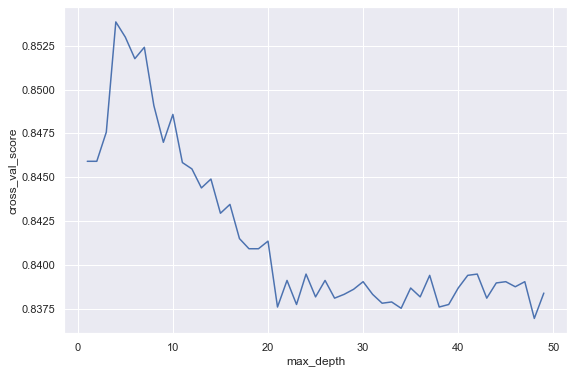

In [414]:
sns.lineplot(x='max_depth', y='cross_val_score', data=scores_data)

In [415]:
scores_data.sort_values('cross_val_score', ascending=False).head()

,max_depth,cross_val_score
0,4,0.853859
0,5,0.852990
0,7,0.852412
0,6,0.851761
0,8,0.849085


In [416]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=5)
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [417]:
clf.score(X_test, y_test)

0.8561822125813449

# Сделаем то же самое с помощью `GridSearchCV`

In [418]:
clf = DecisionTreeClassifier()
parametrs = {'criterion': ['gini', 'entropy'], 'max_depth': range(1,30)}

In [419]:
grid_search_cv_clf = GridSearchCV(clf, parametrs, cv=5)
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 30)})

In [420]:
grid_search_cv_clf.best_params_

{'criterion': 'entropy', 'max_depth': 4}

In [421]:
best_clf = grid_search_cv_clf.best_estimator_

In [422]:
best_clf.score(X_test, y_test)

0.8529284164859002

In [423]:
y_pred = best_clf.predict(X_test)

## Найдем метрики качества

In [424]:
precision_score(y_test, y_pred)

0.7696759259259259

In [425]:
recall_score(y_test, y_pred)

0.5812937062937062

In [426]:
y_predicted_prob =  best_clf.predict_proba(X_test)

In [427]:
y_pred = np.where(y_predicted_prob[:, 1] > 0.5, 1, 0)
print("precision:", precision_score(y_test, y_pred), "\nrecall:", recall_score(y_test, y_pred))

precision: 0.7696759259259259 
recall: 0.5812937062937062


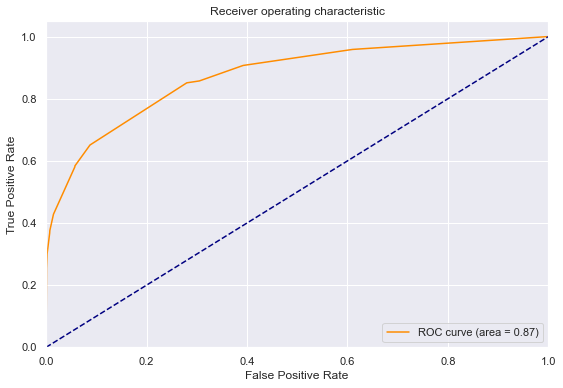

In [428]:
fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])
roc_auc= auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
          label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [429]:
roc_auc

0.8735071009486762

## Обучим Random Forest

In [430]:
clf_rf = RandomForestClassifier(n_jobs=-1)

In [431]:
parameters = {'n_estimators': [10, 20, 30, 40, 50, 80], 'max_depth': [2, 5, 7, 10, 15, 20, 30, 40, 50],
              'min_samples_leaf': [2, 5, 7, 10, 20, 30, 40, 50], 'min_samples_split': [2, 3, 4, 5, 10, 20, 30, 40]}
random_search_cv_clf = RandomizedSearchCV(clf_rf, parameters, n_jobs=-1)

In [432]:
random_search_cv_clf.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
                   param_distributions={'max_depth': [2, 5, 7, 10, 15, 20, 30,
                                                      40, 50],
                                        'min_samples_leaf': [2, 5, 7, 10, 20,
                                                             30, 40, 50],
                                        'min_samples_split': [2, 3, 4, 5, 10,
                                                              20, 30, 40],
                                        'n_estimators': [10, 20, 30, 40, 50,
                                                         80]})

In [433]:
best_param = random_search_cv_clf.best_params_
best_param

{'n_estimators': 50,
 'min_samples_split': 20,
 'min_samples_leaf': 20,
 'max_depth': 20}

In [434]:
best_clf = random_search_cv_clf.best_estimator_

In [435]:
test_score = best_clf.score(X_test, y_test)

In [436]:
test_score

0.8542299349240781

In [437]:
y_pred = best_clf.predict(X_test)

In [438]:
precision_score(y_test, y_pred)

0.7885085574572127

In [439]:
recall_score(y_test, y_pred)

0.5638111888111889

In [440]:
y_predicted_prob =  best_clf.predict_proba(X_test)

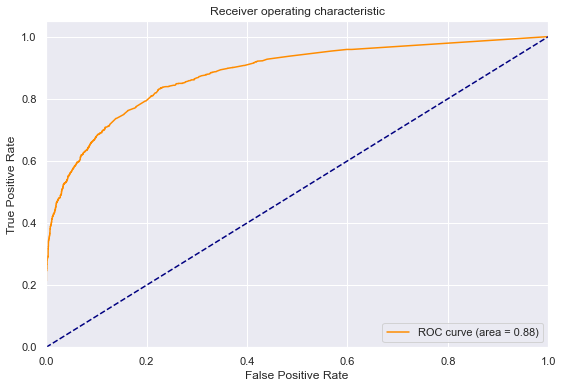

In [441]:
fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])
roc_auc= auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
          label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [442]:
roc_auc

0.881009174034275

In [443]:
best_param

{'n_estimators': 50,
 'min_samples_split': 20,
 'min_samples_leaf': 20,
 'max_depth': 20}

In [444]:
best_clf = RandomForestClassifier(n_estimators=best_param['n_estimators'], min_samples_leaf=best_param['min_samples_leaf'], 
                                  min_samples_split=best_param['min_samples_split'], max_depth=best_param['max_depth'])

In [445]:
parameters = {'n_estimators': [10, 20, 30, 40, 50, 80], 'max_depth': [2, 5, 7, 10, 15, 20, 30, 40, 50],
              'min_samples_leaf': [2, 5, 7, 10, 20, 30, 40, 50], 'min_samples_split': [2, 3, 4, 5, 10, 20, 30, 40]}
random_search_cv_clf = RandomizedSearchCV(clf_rf, parameters, n_jobs=-1)

random_search_cv_clf.fit(X, y)

RandomizedSearchCV(estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
                   param_distributions={'max_depth': [2, 5, 7, 10, 15, 20, 30,
                                                      40, 50],
                                        'min_samples_leaf': [2, 5, 7, 10, 20,
                                                             30, 40, 50],
                                        'min_samples_split': [2, 3, 4, 5, 10,
                                                              20, 30, 40],
                                        'n_estimators': [10, 20, 30, 40, 50,
                                                         80]})

In [446]:
best_clf = random_search_cv_clf.best_estimator_

In [447]:
random_search_cv_clf.best_params_

{'n_estimators': 10,
 'min_samples_split': 10,
 'min_samples_leaf': 20,
 'max_depth': 15}

## Тестовые данные

In [448]:
contest_events_data = pd.read_csv('events_data_test.csv')
contest_events_data

,step_id,timestamp,action,user_id
0,30456,1526893787,viewed,24417
1,30456,1526893797,viewed,24417
2,30456,1526893954,viewed,24417
3,30456,1526895780,viewed,24417
4,30456,1526893787,discovered,24417
...,...,...,...,...
274763,158433,1545846175,discovered,3649
274764,158433,1545846175,passed,3649
274765,158433,1545846283,viewed,20953
274766,158433,1545846283,discovered,20953


In [449]:
contest_submissions_data = pd.read_csv('submission_data_test.csv')
contest_submissions_data

,step_id,timestamp,submission_status,user_id
0,31971,1526800961,wrong,24370
1,31971,1526800976,wrong,24370
2,31971,1526800993,wrong,24370
3,31971,1526801054,correct,24370
4,31972,1526800664,wrong,24370
...,...,...,...,...
42256,120745,1539247150,correct,448
42257,120745,1540380070,wrong,9418
42258,120745,1543165802,correct,8093
42259,120745,1544465625,wrong,25737


In [450]:
contest_events_data['date'] = pd.to_datetime(contest_events_data.timestamp, unit='s')
contest_events_data['day'] = contest_events_data.date.dt.date
contest_events_data.head()

,step_id,timestamp,action,user_id,date,day
0,30456,1526893787,viewed,24417,2018-05-21 09:09:47,2018-05-21
1,30456,1526893797,viewed,24417,2018-05-21 09:09:57,2018-05-21
2,30456,1526893954,viewed,24417,2018-05-21 09:12:34,2018-05-21
3,30456,1526895780,viewed,24417,2018-05-21 09:43:00,2018-05-21
4,30456,1526893787,discovered,24417,2018-05-21 09:09:47,2018-05-21


In [451]:
contest_submissions_data['date'] = pd.to_datetime(contest_submissions_data.timestamp, unit='s')
contest_submissions_data['day'] = contest_submissions_data.date.dt.date
contest_submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1526800961,wrong,24370,2018-05-20 07:22:41,2018-05-20
1,31971,1526800976,wrong,24370,2018-05-20 07:22:56,2018-05-20
2,31971,1526800993,wrong,24370,2018-05-20 07:23:13,2018-05-20
3,31971,1526801054,correct,24370,2018-05-20 07:24:14,2018-05-20
4,31972,1526800664,wrong,24370,2018-05-20 07:17:44,2018-05-20


In [452]:
X_contest = contest_submissions_data.groupby('user_id').day.nunique().to_frame().reset_index()\
        .rename(columns={'day': 'days'})
X_contest.head()

,user_id,days
0,12,1
1,13,2
2,15,3
3,21,1
4,35,3


In [453]:
X_contest.shape

(2803, 2)

In [454]:
contsest_steps_tried = contest_submissions_data.groupby('user_id').step_id.nunique().to_frame().reset_index()\
        .rename(columns={'step_id': 'steps_tried'})

In [455]:
contsest_steps_tried.head()

,user_id,steps_tried
0,12,1
1,13,29
2,15,11
3,21,30
4,35,9


In [456]:
X_contest = X_contest.merge(contsest_steps_tried, on='user_id', how='outer')

In [457]:
X_contest.shape

(2803, 3)

In [458]:
X_contest.head()

,user_id,days,steps_tried
0,12,1,1
1,13,2,29
2,15,3,11
3,21,1,30
4,35,3,9


In [459]:
X_contest = X_contest.merge(contest_submissions_data.pivot_table(index='user_id', 
                                 columns='submission_status',
                                 values='step_id',
                                 aggfunc='count',
                                 fill_value=0).reset_index())

In [460]:
X_contest.head()

,user_id,days,steps_tried,correct,wrong
0,12,1,1,1,0
1,13,2,29,29,36
2,15,3,11,10,30
3,21,1,30,24,103
4,35,3,9,7,35


In [461]:
X_contest.shape

(2803, 5)

In [462]:
X_contest['correct_ratio'] = X_contest.correct / (X_contest.correct + X_contest.wrong)
X_contest.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,12,1,1,1,0,1.000000
1,13,2,29,29,36,0.446154
2,15,3,11,10,30,0.250000
3,21,1,30,24,103,0.188976
4,35,3,9,7,35,0.166667


Отберем признаки на основе датасета **contest_events_data**:

In [463]:
X_contest = X_contest.merge(contest_events_data.pivot_table(index='user_id', 
                                 columns='action',
                                 values='step_id',
                                 aggfunc='count',
                                 fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')

In [464]:
X_contest.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,12,1.0,1.0,1.0,0.0,1.000000,14
1,13,2.0,29.0,29.0,36.0,0.446154,105
2,15,3.0,11.0,10.0,30.0,0.250000,1
3,21,1.0,30.0,24.0,103.0,0.188976,98
4,35,3.0,9.0,7.0,35.0,0.166667,70


In [465]:
X_contest = X_contest.fillna(0)
X_contest.shape

(6184, 7)

In [466]:
X_contest = X_contest.set_index('user_id', drop=True)
X_contest.head()

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
12,1.0,1.0,1.0,0.0,1.000000,14
13,2.0,29.0,29.0,36.0,0.446154,105
15,3.0,11.0,10.0,30.0,0.250000,1
21,1.0,30.0,24.0,103.0,0.188976,98
35,3.0,9.0,7.0,35.0,0.166667,70


## Предскажем, сможет ли пользователь успешно закончить онлайн курс

In [467]:
y_contest_pred_proba = best_clf.predict_proba(X_contest)

In [468]:
y_contest_pred_proba

array([[0.75451398, 0.24548602],
       [0.        , 1.        ],
       [0.5633756 , 0.4366244 ],
       ...,
       [0.96547799, 0.03452201],
       [0.96547799, 0.03452201],
       [0.96547799, 0.03452201]])

In [469]:
ans_df = pd.DataFrame({'user_id': X_contest.index, 'is_gone': y_contest_pred_proba[:, 1]})

## Запись результата в файл

In [498]:
ans_df.to_csv('y_pred_prob.csv', index=False)

In [499]:
pd.read_csv('y_pred_prob.csv').head()

,user_id,is_gone
0,12,0.245486
1,13,1.000000
2,15,0.436624
3,21,0.884420
4,35,0.435252
